##### 2020 George Mihaila.

# Find new sentiments in text data


<td>
    <a target="_blank" href="https://jupyterlab.hpc.unt.edu/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run on Talon</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/unt_hpc/blob/master/workshops/march_3_2019/README.md"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Train custom word embeddings using a small Neural Network.
 * Use Lime to explain model predictions.
 * Use the embedding model to create review embeddings.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

## Dataset

* **data/imdb_reviews_50k.csv** contains all movie revies and their sentiments:
    
* **data/movies_reviews_embeddings_part1.npy** and **data/movies_reviews_embeddings_part2.npy** contain BERT Embeddings of all `50,000` movie revies. They are saved in numpy format binary. 
   They are the output of running `SentenceTransformer` on all the text using `bert-base-nli-mean-tokens` pretrained model.

## Imports

In [1]:
import os
# avoid using GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from lime.lime_text import LimeTextExplainer


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

[nltk_data] Downloading package stopwords to /home/gm0234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gm0234/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Functions

In [2]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Data Prep

## Read CSV

In [3]:
# read reviews from csv file
review_sentiments_df = pd.read_csv('../data/imdb_reviews_50k.csv')
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['review'].values, review_sentiments_df['sentiment'].values
# print first 2 examples
review_sentiments_df.head(n=2)

,review,sentiment
0,"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",0
1,"I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.",0


## BERT Embeddings

In [4]:
# load for future predicitons
embedding_model = SentenceTransformer(model_name_or_path='bert-base-nli-mean-tokens',
                                    device=torch.device('cpu'))
# load embeddings for all reviews
reviews_embeddings_part1 = np.load('../data/movies_reviews_embeddings_part1.npy')
reviews_embeddings_part2 = np.load('../data/movies_reviews_embeddings_part2.npy')
# concatenate parts
reviews_embeddings = np.concatenate((reviews_embeddings_part1, reviews_embeddings_part2))

print('Bert Embeddings Loaded: ', reviews_embeddings.shape)

Bert Embeddings Loaded:  (50000, 768)


# Simple Neural Network

## Config

In [5]:
EMBEDDING_SIZE = 768
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [6]:
# split train 80% - test 20% 
embeddings_train, embeddings_test, sentiments_train, sentiments_test = train_test_split(reviews_embeddings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
embeddings_train, embeddings_valid, sentiments_train, sentiments_valid = train_test_split(embeddings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', embeddings_train.shape)
print('Validation shape:', embeddings_valid.shape)
print('Test shape:      ', embeddings_test.shape)

Train shape:      (36000, 768)
Validation shape: (4000, 768)
Test shape:       (10000, 768)


## Data Generators

In [7]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((embeddings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((embeddings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 16)                12304     
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train for 72 steps, validate for 8 steps
Epoch 1/20
72/72 [==============================] - 1s 11ms/step - loss: 0.4770 - accuracy: 0.7674 - val_loss: 0.4258 - val_accuracy: 0.8015
Epoch 2/20
72/72 [==============================] - 1s 7ms/step - loss: 0.4183 - accuracy: 0.8065 - val_loss: 0.4067 - val_accuracy: 0.8110
Epoch 3/20
72/72 [==============================] - 0s 7ms/step - loss: 0.4033 - accuracy: 0.8150 - val_loss: 0.4005 - val_accuracy: 0.8160
Epoch 4/20
72/72 [==============================] - 

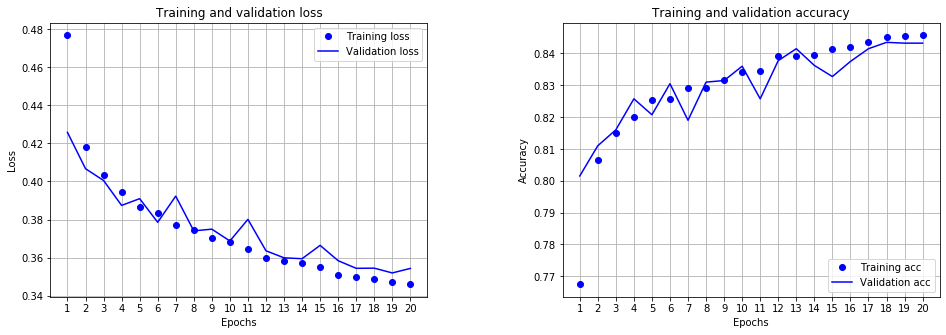

In [8]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, input_shape=(EMBEDDING_SIZE,), activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)
# plot training curves
plt_history(history_dict=history.history)

## Evaluation

In [9]:
# get model predicitons
sentiments_predicitons = model.predict_classes(embeddings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      4948
           1       0.82      0.87      0.84      5052

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



## Explain Model

In [10]:
example_sample = 'Movie was great! I hate it!'

# explain model prediciton
def classifier_dn(texts):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  encodings_texts = embedding_model.encode(sentences=texts, 
                                          batch_size=500, 
                                          show_progress_bar=True)
  encodings_texts = np.array(encodings_texts)
  for encoding_text in encodings_texts:
    preds = model(encoding_text.reshape(1,768))[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(example_sample,  classifier_dn, num_features=EMBEDDING_SIZE)
# output to cell
exp.show_in_notebook(text=True)

/home/gm0234/.local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
Batches: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


# Run Best k-means model

In [11]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

In [12]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
#     cluster_plot.savefig("pca_plot.png")
  return reduced_features

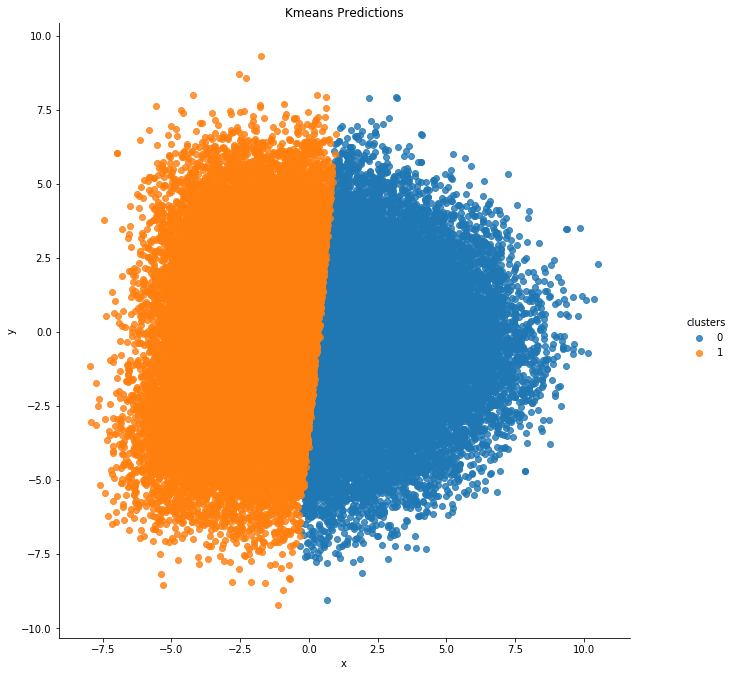

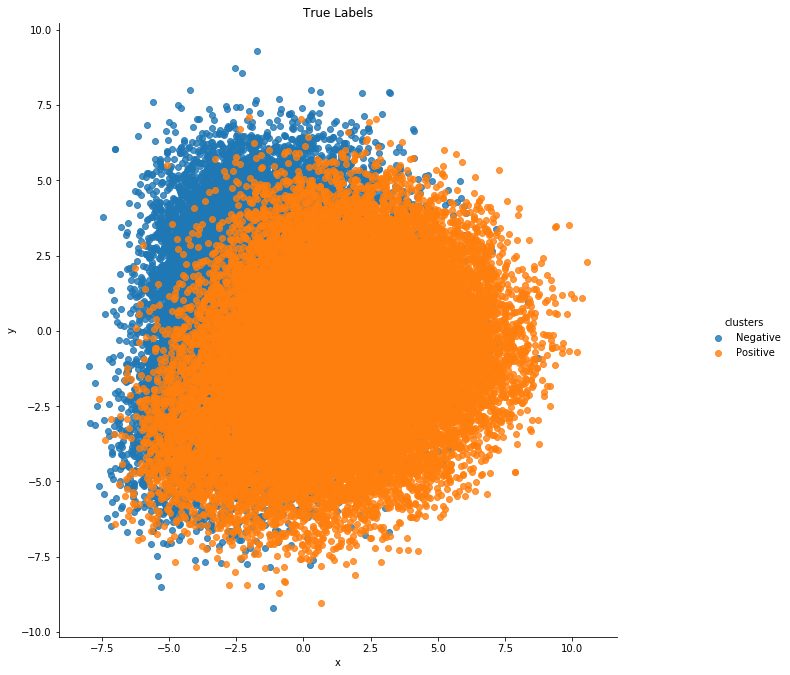



Found labels: [0, 1]



,labels,cluster_match
0,0,Positive:16532 Negative:5094
1,1,Negative:19906 Positive:8468


In [13]:
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [14]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [15]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



,labels,cluster_match
0,0,Negative:14629 Positive:3823
1,1,Positive:13523 Negative:3058
2,2,Positive:7654 Negative:7313


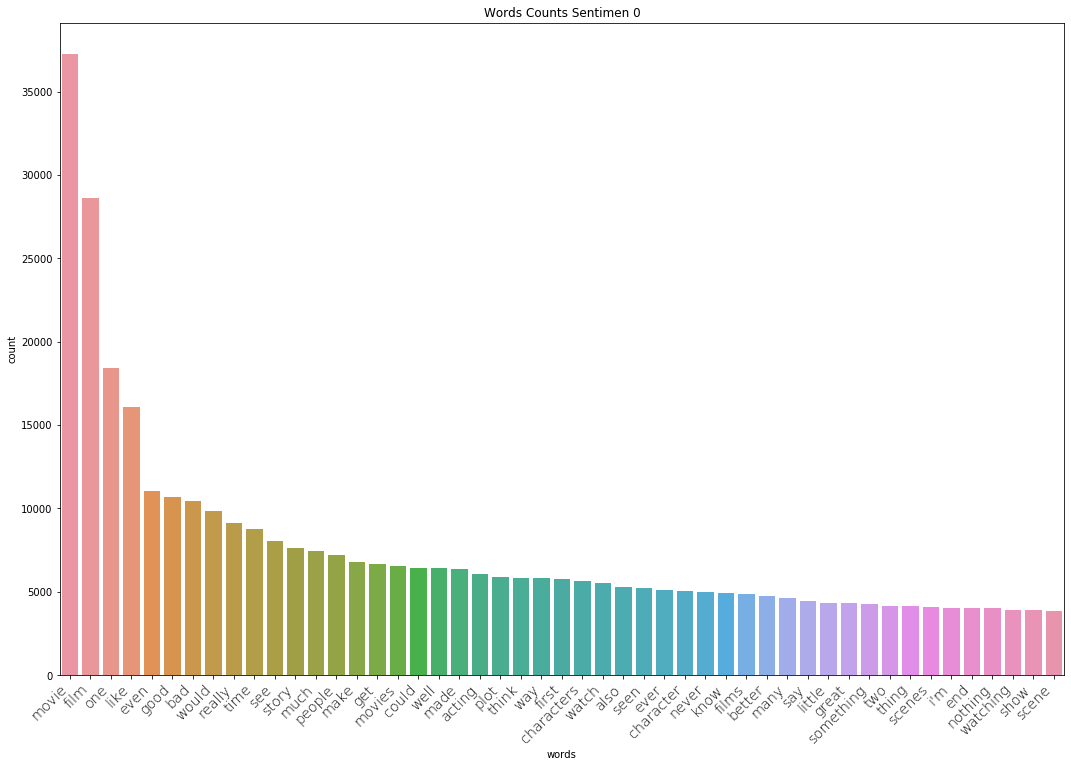

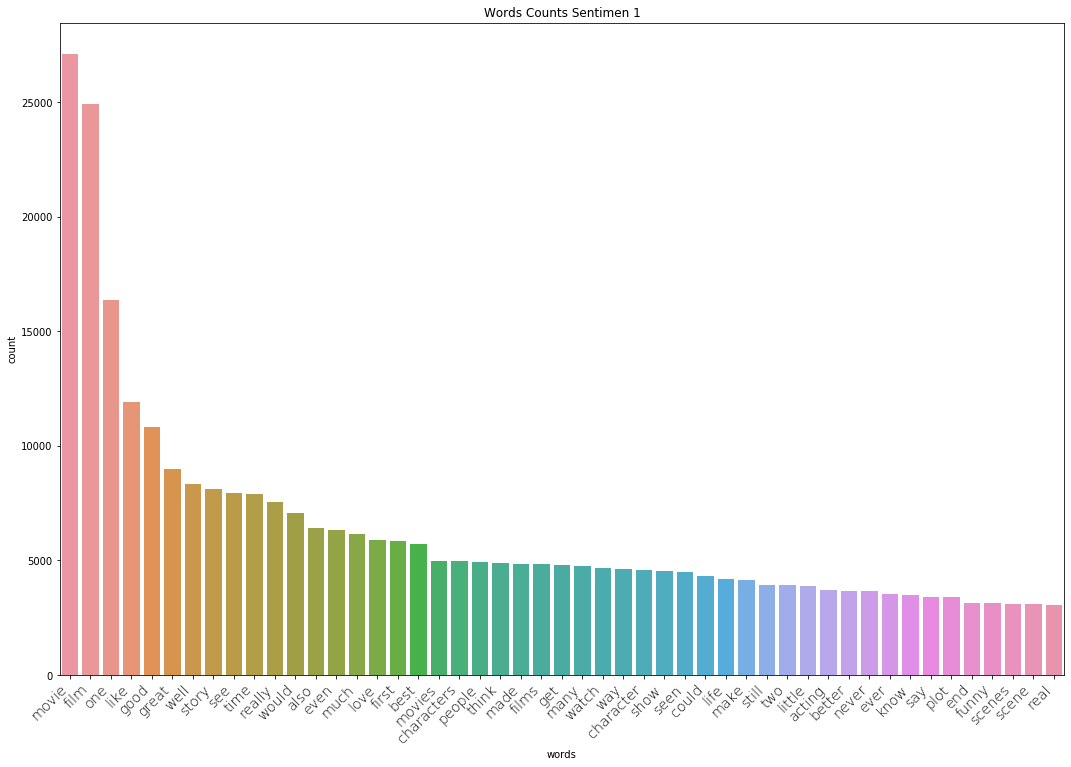

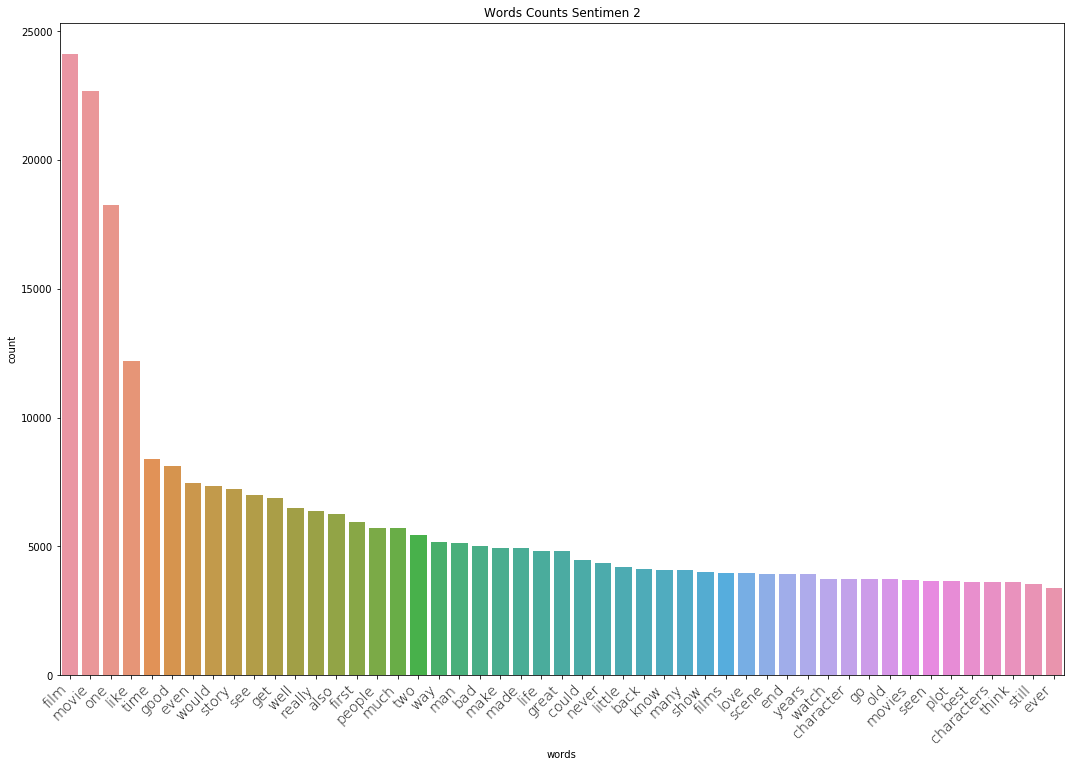

In [16]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

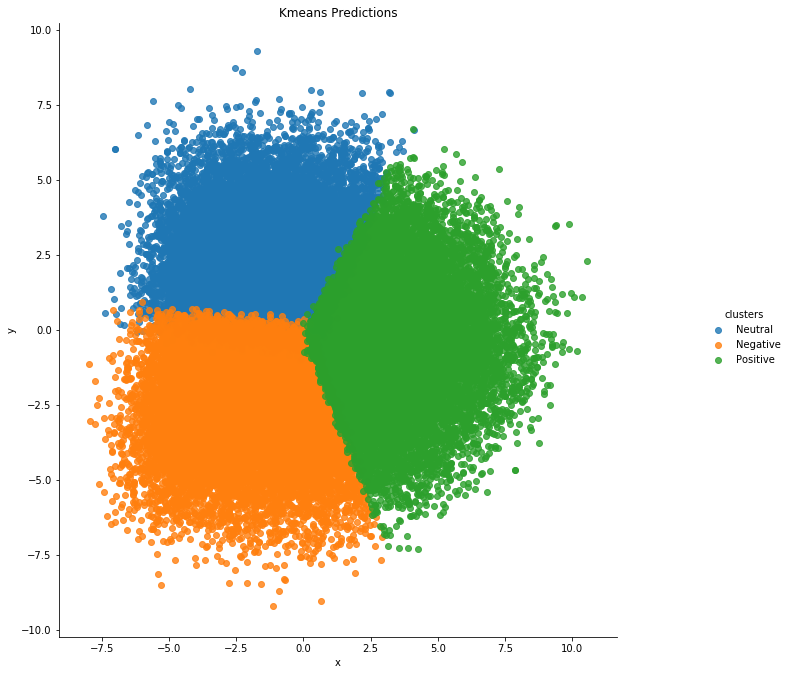

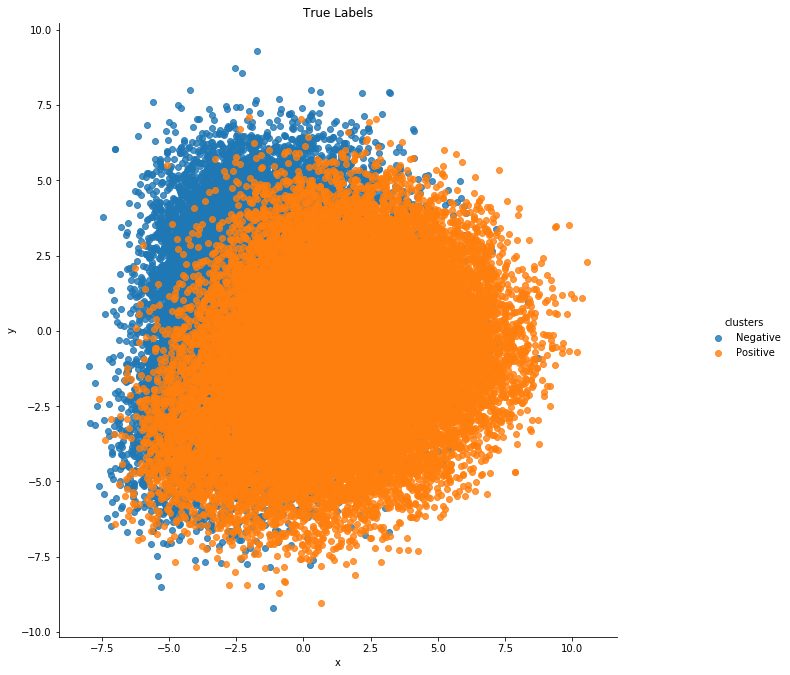

In [17]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [18]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

,Text,Label Sentiment,Prediction Sentiment
0,"Tobe Hooper is quite possibly the biggest fluke the horror genre has to offer. Like any other horror fan, I loved the Texas Chainsaw, but I think that in order to put your name in front on a movie title, you should have at least more than one hit movie. I can't really think of any other movie Hooper has done (on his own, don't count Poltergeist) that has really made an impact on the horror genre or film world. And this movie, Night Terrors, just backs up my point.<br /><br />Poor Robert Englund, I give him credit for at least doing a good job with the awful material he was given. He did what he could. As for the movie itself? Pure drudge. Unnecessary nude scenes every five minutes, a story that must have been penned in an our, and really just awful scenery, music, and cinematography. Nothing in this film is redeemable. Don't waste your time.<br /><br />Overall, 1 out of 10. I feel sorry for Hooper, his career seems like it was over before it really ever got started. I hope that he's able to pump out at least one more good flick, that way he can do his cult status some justice.<br /><br />",Negative,Neutral
1,"Hollywood has churned out yet another garbage that's wildly overhyped and underwhelming on a first-time viewing basis. Hannibal is bad, terrible, inept, lame, droll, idiotic, contrived, laughable and utterly atrocious (no pun intended). Minor spoilers follow...<br /><br />This movie has huge logic holes - more than any Bruckheimer/Bay movie - or for that matter - any movie that exemplify the indulgence of Hollywood exaggeration. It's a slick Hollywood production designed to cash in on Hannibal Lector mania, directed by ""so-somber-he-takes-this-way-too-seriously"" hack director Ridley Scott and produced by a hack Italian producer with an inflated ego whose credo is ""doesn't matter whether film is s**t, money is good"".<br /><br />I can't get over the fact that acclaimed screenwriters David Mamet and Steven Zaillian wrote this tripe adapted from a lame and pretentious book by a good-novelist-turned-hack-author Thomas Harris. David and Steven - well-known and immensely talented screenwriters - wasted their effort on a poor screenplay in exchange for fat paychecks. Another factor in the disappointment of this film.<br /><br />There are too many ludicrous scenes to list that are laughable in clunky execution and poor logic e.g. Starling/Pazzi cell-phone in the midst of Lecter pursuit that turns up Inspector Pazzi as the victim. Not to mention laughably bad dialogues delivered by Tony Hopkins with a smirk and Julianne Moore, Ray Liotta and others who cannot act with the straight face. Hopkins gives the true meaning of ""scenery-chewing"" along with hammy acting by Gary Oldman as a deformed psychopath bent on exacting revenge against Lecter.<br /><br />The gore effect is good, but only serves to repulse rather than provide suspense which is notably absent from Hannibal. The predecessor - Silence of the Lambs - is more believable with tension and suspense. Suspense is what made Silence of the Lamb work as a spectacular mix of psychological horror and thriller, not to mention superbly written and tensely directed. The ""brain dinner"" sequence is so laughably fake it borders on self-parody.<br /><br />The ending is kinda blatant and idiotic - are we supposed to believe that Lecter is still a menace to society with the last shot establishing his glittering eye glaring at you? Ooh, scary... <br /><br />",Negative,Neutral
2,"I guess only a selected number of audience members really had any interest in watching how a male hustler in New York operates but I'd be willing to bet that even these brave souls were turned off by the irritating patchwork technique and deliberately muffled sound recording on display here; the fact that these inherent 'defects' were a direct result of the film's low-budget/underground/experimental nature is, I'd say, beside the point. Anyway, for those so inclined

## k=4 sentiments

In [19]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [20]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



,labels,cluster_match
0,0,Negative:5349 Positive:4498
1,1,Positive:6652 Negative:4083
2,2,Positive:10695 Negative:2207
3,3,Negative:13361 Positive:3155


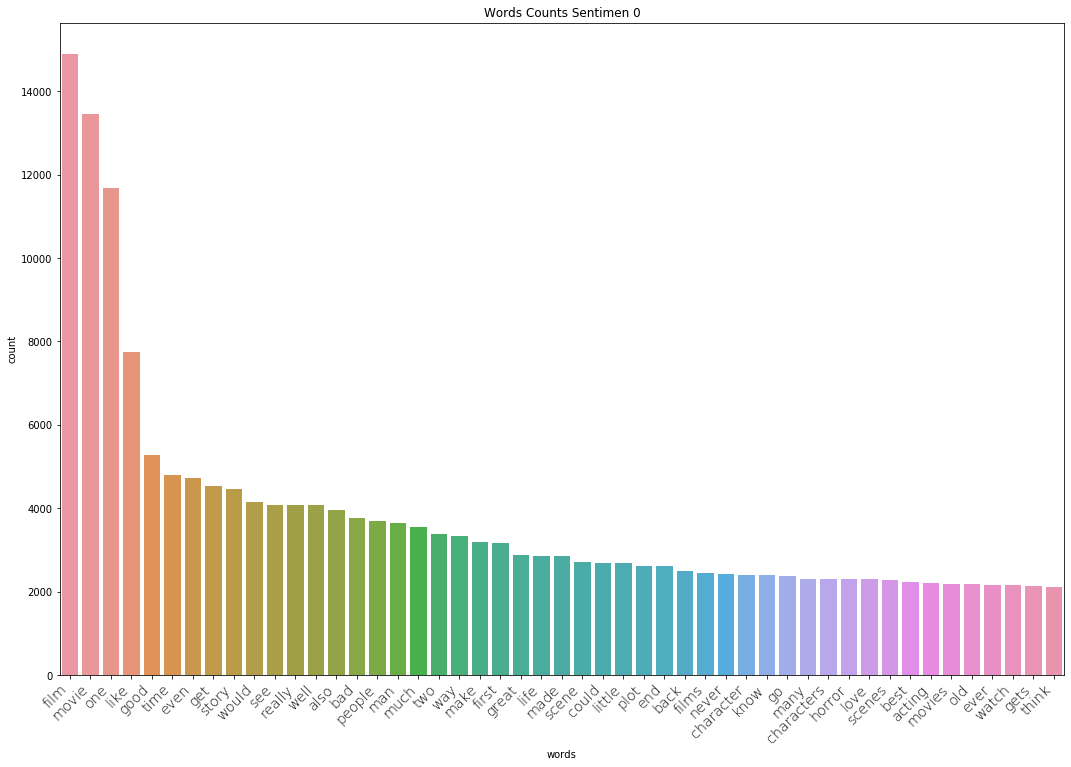

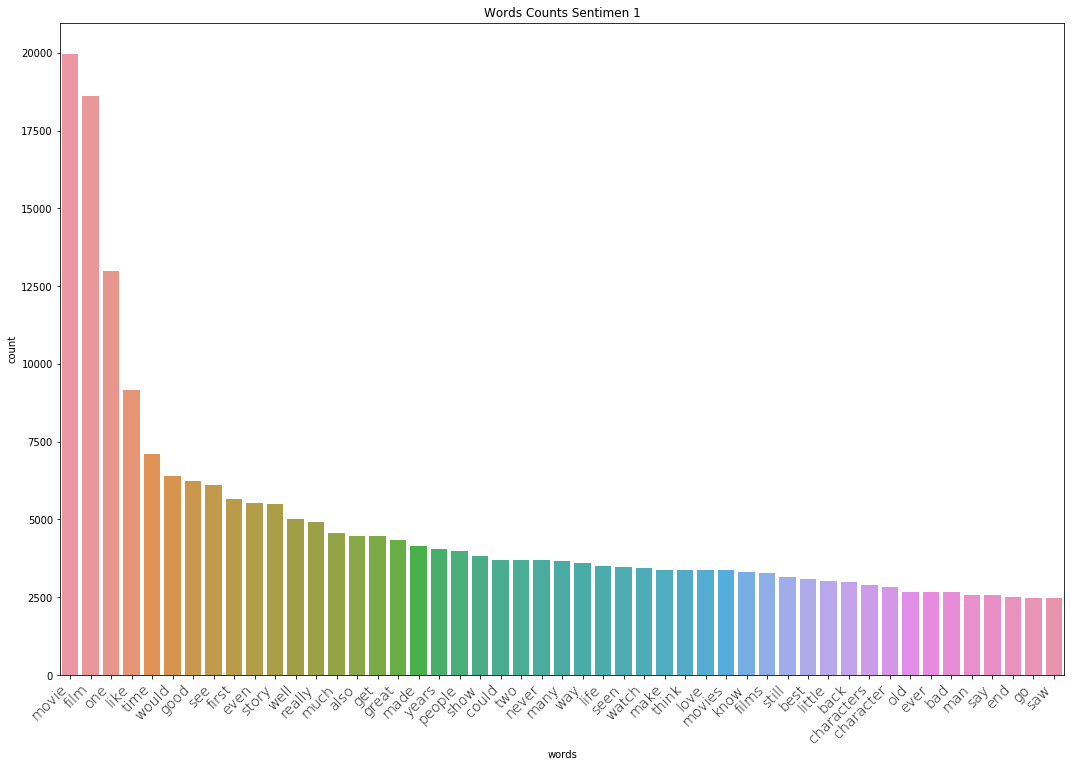

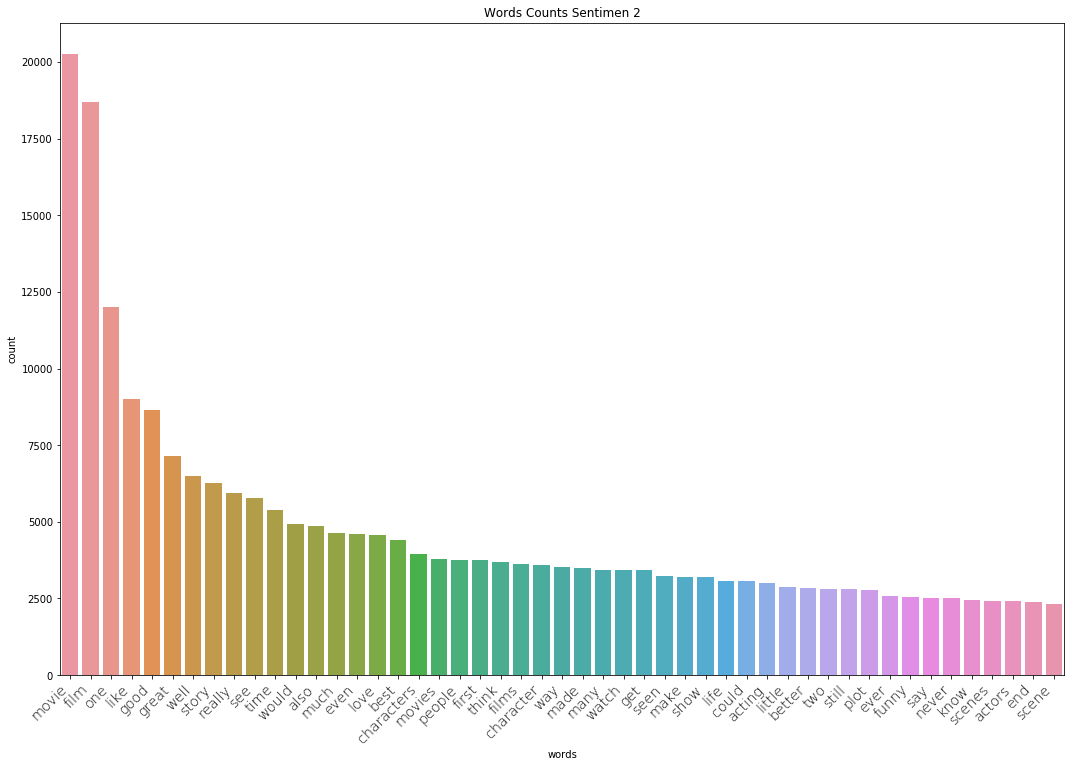

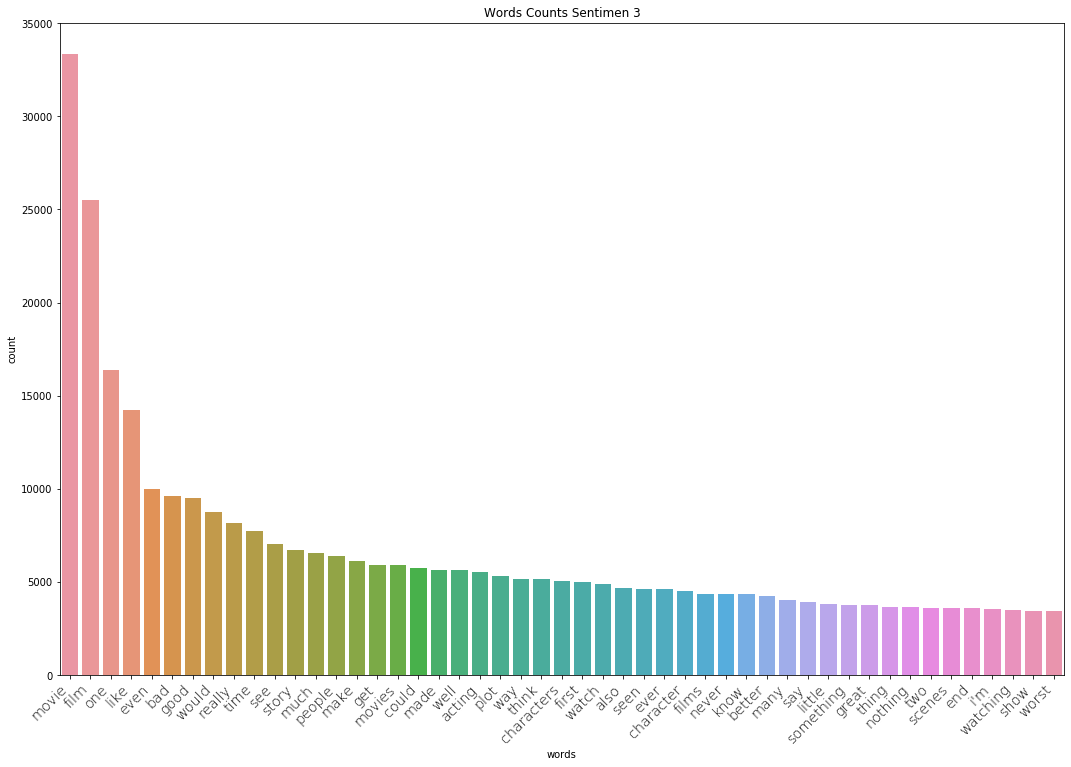

In [21]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

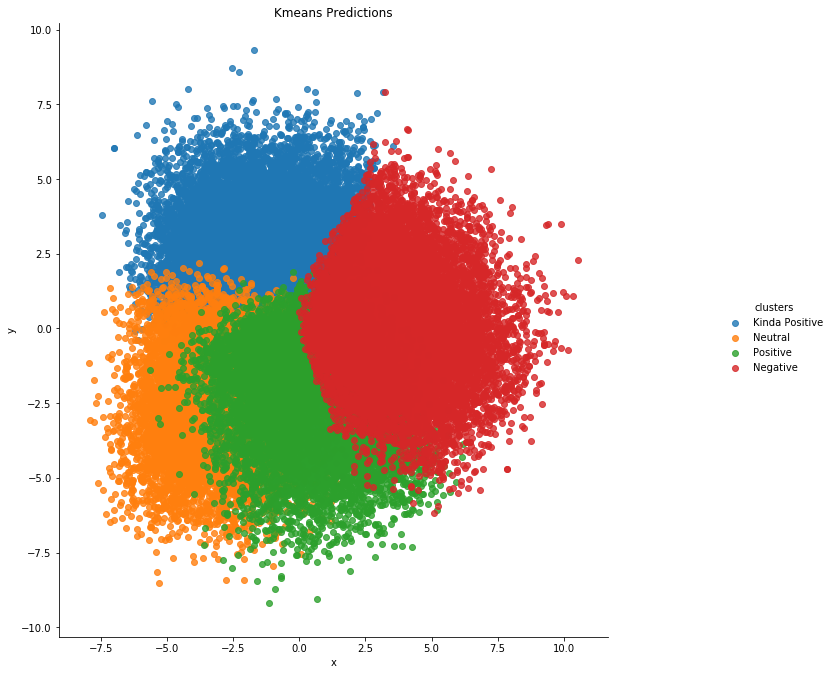

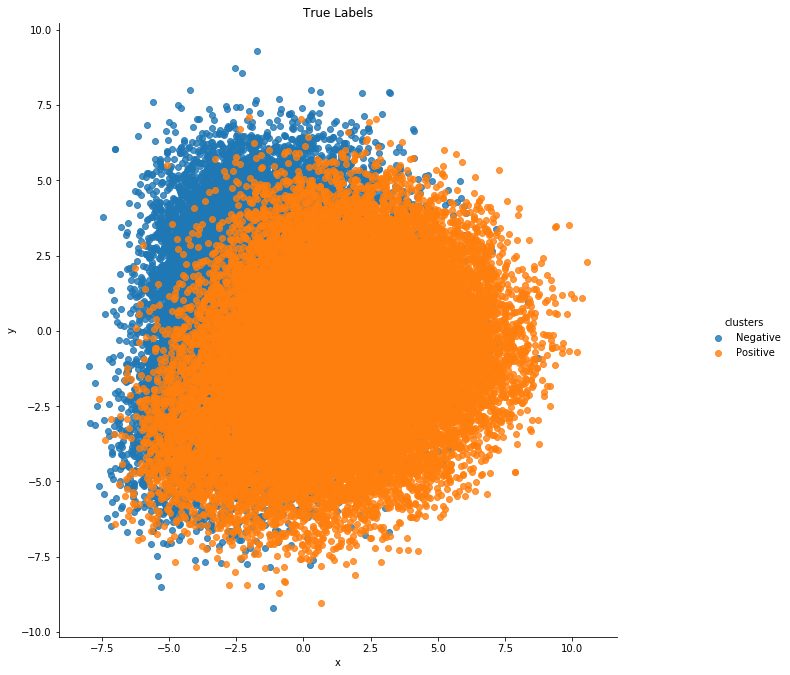

In [22]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [23]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

,Text,Label Sentiment,Prediction Sentiment
0,"A bigoted soldier kills a man for being Jewish and tries to pin it on a fellow soldier. Not as good as the novel it was based on (""The Brick Foxhole"") in which it was a gay man who was killed...but Hollywood wouldn't touch that in 1947. That said, it's still a very good film. The anti-Semitism is handled very well, but it's hammered into the audience that bigotry is bad...well duh! But this was 1947. The picture is well-acted by the entire cast (especially Robert Young and Robert Ryan) and the tone is very dark...as it should be. Very atmospheric too. A deserved big hit in its day...well worth seeing.",Positive,Neutral
1,"It's all about getting what you want when you want it. And the message of Bluebeard's Eighth WIfe is to be careful what you wish for, until what you wish for wishes for you.<br /><br />Most men have heard the stories about what happens when your sexual frustration isn't relieved and a certain part of your anatomy turning blue. Misogynistic pirates aside, Cooper plays a very wealthy man who is very accustomed to getting what he wants whenever he wants it, learning only too late that it wasn't what he expected and never learning his lesson until he runs into the feisty Claudette Colbert. Through a twisted (in soul and in practice) business deal, he ends up marring/buying her with the intent of bedding her, but she will have none of it (literally) and frustrates him at every turn, and corner, and room, and tourist attraction.<br /><br />The film has definite French sensibilities which means it has strong double-entendres and boudoir humor for the day and a sharp edge you're not accustomed to (and may not enjoy seeing) in either Cooper or Colbert. The whole reason I watched the film was because they are ""likable"" actors, and the whole point of this movie is that they're unlikable people, or at least likable people who have developed unlikable traits to protect themselves, they think, from the world. <br /><br />If you can accept it on its own terms you'll find satisfaction in this witty and sophisticated film...and satisfaction, as we said, is what it's all about. Such a movie with such a cast only comes around, after all, once in a...ummm...blue moon.",Positive,Neutral
2,"This film can't make up its mind whether its message is ""humans are evil and bad and animals are sweet and blameless"" or ""don't ever go in the water again."" A fisherman (Nolan) is out to nab a killer whale, a very bad thing, but when he accidentally (ACCIDENTALLY mark you) hits a pregnant cow instead of her mate, the cow -- and I use the word in all senses -- who is obviously a sick psycho-bitch and the canonical villain of the piece -- throws herself against the propellers trying to chew herself to bits in the most distressing and hideous not to mention ineffectual method of killing herself. (I doubt it was her first.) When her unborn fetus aborts from her hideous self-inflicted wounds, her mate goes mental with revenge and swears to hurt, kill and mutilate every human who even so much as talks to Nolan. Obviously as among humans, total psychos date other total psychos.<br /><br />The film reeks of half-thought out anti-human message, ""the poor poor whale!! the evil men must suffer and die!"" and yet, it does not succeed in demonizing Nolan at all. It's true that when he set out his motives were selfish and cruel, but at the first squeal of the first whale he grows a heart and, as the film progresses, he grows more and more compassionate to the whale's pain until it seems he will walk out on the ice and give himself to the whale, just to make it feel a little better.<br /><br />The films final journey, in which Nolan follows the whale on a bizarre journey to the north, reminds me of Melville's eerie man-whale connection, and for a moment hinted at a truly interesting conclusion, where these two husbands might connect, understand even respect each other in their own grief, for Nolan lost hi

# Custom Samples

In [24]:
custom_text = "This workshop roks!!"

encodings_texts = embedding_model.encode(sentences=[custom_text], 
                                          batch_size=1, 
                                          show_progress_bar=True)
encodings_texts = np.array(encodings_texts)
kmean_label = kmean_model.predict(tf.get_static_value(encodings_texts))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])

Batches: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

Text:  This workshop roks!!
Sentiment:  Negative
